# Implement a basic neural network from scratch
 * Prerequisite: basic concepts of derivatives. Partial derivative, chain rule, quotient rule etc.

A lot of the basics of this note is built upon the perceptron algorithm. Read that note first. Apology upfront for all the cumbersum notations below. Those will be useful in the next notebook on RNN, so I'll keep it consistent here.

This is a terribly drawn but still valid fully connected neural net with 3 input features (x1, x2, x3), 1 hidden layer (node1, node2), and 1-dimensional output (y). Not shown in this picture is a bias term, to prevent trivial prediction at `x=[0, 0, 0]` regardless of weights. We could introduced the bias term by a constant node with value=1, but I decided to separate it out for easier reading later.

We say it's fully connected because each node is connected with all nodes in the next layer. This can be seen as a generic representation. A sparse network is simply one with most weights=0.

We notate the weights as: `w[i,j]` is the weight between node_i and input x_j

![nn](imgs/nn.png)

Before getting into details, we claim that neural network can help us with cognitive tasks by telling us about whether an object is. I wanted to build my own with some funny objects, but decided that's too much work. So we'll use the number dataset that's readily available.

In [167]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
from keras.datasets import mnist

(x_train_raw, y_train),(x_test_raw, y_test) = mnist.load_data()
x_train_raw.shape, y_train.shape, x_test_raw.shape, y_test.shape

2025-09-12 23:55:26.990868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 23:55:27.063891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757735727.085664  886704 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757735727.092652  886704 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-12 23:55:27.172324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

I'll compress the images to simplify calculations later

In [523]:
def compress(img, fold=2):
    n = img.shape[0]
    com = [img[i] for i in range(n) if i % fold == 0]
    com = [[c[i] for i in range(len(c)) if i % fold == 0] for c in com]
    com = com[1:-2]
    com = [c[1:-2] for c in com]
    return np.array(com)

x_train = np.array([compress(x, 2) for x in x_train_raw])
x_test = np.array([compress(x, 2) for x in x_test_raw])

before compression


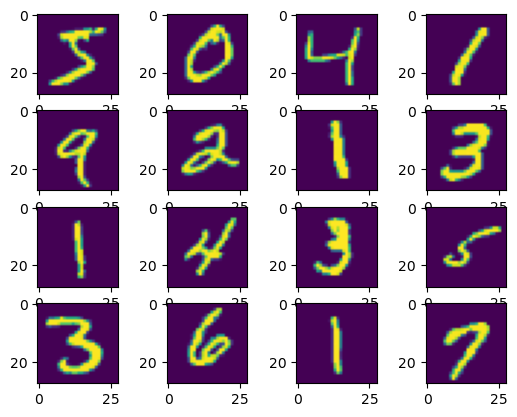

In [24]:
print("before compression")
imgs = x_train_raw[[i for i in range(16)]]
fig, axes = plt.subplots(4,4)
for i in range(16):
    axes[int(i/4)][i%4].imshow(imgs[i])

after compression
(16, 11, 11)


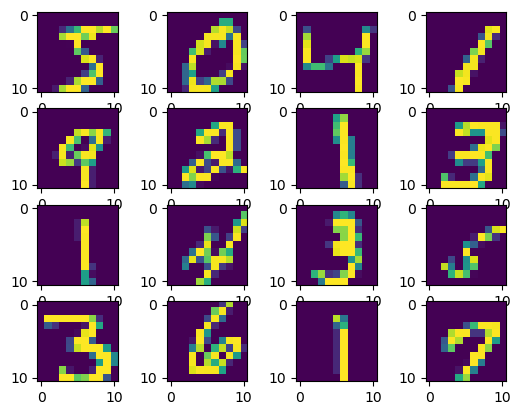

In [31]:
print("after compression")
imgs = x_train[[i for i in range(16)]]
fig, axes = plt.subplots(4,4)
for i in range(16):
    axes[int(i/4)][i%4].imshow(imgs[i])
print(imgs.shape)

OK, I can live with 2 fold compression

## Formulation

Here's the formula for the simplified network at the very top, given the feature values of a single data point (x1, x2). The actual representation might vary in different tutorials but the idea is the same. You multiply each feature value with its weight towards nodes. The value at each node is the sum of value*weight of all features connected to it. Finally, a bias term `b` is added before the activation function.

For activation, we use the good old sigmoid function to go from input layer to the hidden layer, aka first layer. As a reminder, the sigmoid function is defined as

$$\sigma(s_i) = \frac{1}{1 + e^{-s_i}}$$

where $s_i$ is the weighted sum at hidden layer node i. However, we'll do it differently at the output layer. As we want to predict the probabilities of the output being 0-9 respectively, it makes sense to have them add up to 1. The softmax function forces the sum of all probabilites to be 1, so we'll use it for the output layer

$$\sigma(s_i) = \frac{e^{s_i}}{\sum_{j=1}^{j=m}(e^{-s_j})}$$

where m is the number of nodes in the output layer and $s_i$ is the weighted sum at output node i. Note that softmax at node_i depends on the weighted sum at other nodes.

Writing all items out, we have

Hidden layer:
    
$$
\begin{bmatrix}
node1 \\
node2 \\
\end{bmatrix}
=
\sigma_{sigmoid}(
\begin{bmatrix} 
w_{11} & w_{12} & w_{13} \\
w_{21} & w_{22} & w_{23}
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix}
+
\begin{bmatrix}
b_1 \\
b_2 \\
b_3
\end{bmatrix}
)
$$

Output layer

$$
y = 
\sigma_{softmax}(
\begin{bmatrix}
v_1 & v_2
\end{bmatrix}
\begin{bmatrix}
node1 \\
node2 \\
\end{bmatrix}
+
d
)
$$

$w$ and $v$ are the weights and $b, d$ are the bias terms. 

## Feed forward, from input to prediction

### Hidden layer

Suppose there are n samples, to go from those $x$ values to the hidden layer, we include all samples and layout the entire thing in a matrix form. Here
 * $N^i$ means the vector $[node_1, node_2]$ calculated from the ith sample.
 * $X^i$ means $[x_1, x_2, x_3]$ of the ith sample
 * $W$ means the entire weight vector, transposed to whichever shape it needs to be for matrbix match, either 2x3 or 3x2
 * Similarly, $B$ is the bias term vector.

$$
\begin{bmatrix} 
N^1 \\
N^2 \\
... \\
N^n
\end{bmatrix}
=
\sigma(
\begin{bmatrix} 
X^1 \\
X^2 \\
... \\
X^n
\end{bmatrix}
W
+
\begin{bmatrix}
B \\
B \\
... \\
B \\
\end{bmatrix}
)
$$

which is really:

$$
\begin{bmatrix} 
node_{11} & node_{12} \\
node_{21} & node_{22} \\
... \\
node_{n1} & node_{n2}
\end{bmatrix}
=
\sigma(
\begin{bmatrix} 
x_{11} & x_{12} & x_{12} \\
x_{21} & x_{22} & x_{23} \\
... \\
x_{n1} & x_{n2} & x_{n3}
\end{bmatrix}
\begin{bmatrix}
w_{11} & w_{21} \\
w_{12} & w_{22} \\
w_{13} & w_{23}
\end{bmatrix}
+
\begin{bmatrix}
b_1 & b_2 \\
b_1 & b_2 \\
... \\
b_1 & b_2 \\
\end{bmatrix}
)
$$

### Output layer

Similarly, to get to the output, we have

$$
\hat{Y} =
\begin{bmatrix}
\hat{y_1} \\
\hat{y_2} \\
... \\
\hat{y_n}
\end{bmatrix}
=
\sigma(
\begin{bmatrix} 
node_{11} & node_{12} \\
node_{21} & node_{22} \\
... \\
node_{n1} & node_{n2}
\end{bmatrix}
\begin{bmatrix}
v_1 \\
v_2
\end{bmatrix}
+
\begin{bmatrix}
d \\
d \\
..\\
d
\end{bmatrix}
)
= \sigma(Nodes\times V + D)
$$

($\sigma$ represents either sigmoid or softmax)

**In the matrix form, the formulation is easily extendable to more complex networks**. The same principal/math applies. To do the number classification, we obviously need to go beyond just 3 input features. In fact, the image is a 11x11 grid (after compression), meaning 121 input features. So instead of $X^i$ representing $[x_1, x_2, x_3]$, we have it represent $[x_1, x_2, ..., x_{121}]$. The same goes with w.

## Let's go even further and do some predictions!

To tackle the number prediction problem, we use a larger network such that
 * input layer has 121 features
 * 1st layer has 20 nodes
 * output layer has 10 nodes, representing 0-9.

Since we don't know what the weights and biases are, we will just use some random values and parameterized the functions. Summarizing all the calculations above, we have a basic naive predictor:

In [399]:
class NaiveNeuralNet:
    def __init__(self):
        self.w = np.random.randn(20,121)
        self.v = np.random.randn(10,20)
        self.b = np.random.randn(20)
        self.d = np.random.randn(10)

    @staticmethod
    def softmax(x):
        x = np.array(x, dtype=np.float128)
        # to avoid overflow due to super large x, we subtract the max
        xx = x - np.max(x)
        exp = np.exp(xx)
        return exp / exp.sum(axis=1, keepdims=True)

    @staticmethod
    def sigmoid(x):
        x = np.array(x, dtype=np.float128)
        return 1 / (1 + np.exp(-x))

    def predict_scores(self, x):
        # feed forward. Here x is in the same format as the training samples
        num_samples = x.shape[0]
        # flatten the samples into 121 features.
        x_flat = np.array([a.flatten() for a in x])
        # Hidden layer
        # add a bias term for each sample.
        bias_1 = np.array([self.b for i in range(num_samples)])
        sum_1 = x_flat @ self.w.T + bias_1
        activated_1 = self.sigmoid(sum_1)
        # Output layer
        bias_2 = np.array([self.d for i in range(num_samples)])
        sum_2 = activated_1 @ self.v.T + bias_2
        activated_2 = self.softmax(sum_2)
        return activated_2

    def predict(self, x):
        pred = self.predict_scores(x)
        indices = [np.argmax(p) for p in pred]
        return np.array(indices)

In [400]:
net = NaiveNeuralNet()
net.predict_scores(imgs[:3])

array([[9.35205551e-01, 1.67069978e-03, 3.01476927e-03, 1.65483827e-02,
        5.51737888e-04, 2.71009969e-05, 3.91528375e-02, 7.73713606e-05,
        2.21130439e-04, 3.53041919e-03],
       [2.31454335e-01, 2.78708098e-04, 1.07199313e-03, 6.77965641e-01,
        2.51910835e-02, 3.69573108e-05, 4.92609756e-02, 4.87169969e-03,
        2.35934251e-03, 7.50926412e-03],
       [3.77629835e-01, 2.57955233e-04, 2.71079986e-03, 5.18559401e-01,
        1.70052707e-02, 3.04029674e-05, 5.29631525e-03, 5.85975271e-02,
        1.87688003e-02, 1.14369200e-03]], dtype=float128)

In [401]:
net = NaiveNeuralNet()
net.predict(imgs)

array([8, 8, 8, 5, 8, 5, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8])

**Of course, the predictions are all over the places!** A prediction from randomly generated parameters is expected to be very random. Therefore we need to adjust the parameters via model training.

## How to find best set of parameters?

Unlike linear regression, there's no algebraic solution to find optimal coefficients. We
need to iteratively "guess" a set of weights, calculate the errors, and infer from the errors
how we should modify the weights towards a better direction (lower errors).

N x (update weights -> calculate error -> somehow find out how to update weights based on the error)

### Loss function and cost

The function that calculates such errors is called the loss function. The sum of the loss
over all the samples is called the cost.
The practice of using
errors at output layer to update all the weights is called
**back propagation**, since we are going backwards. How do we use errors? Would be nice if
someone can tell me something like "if you change $w_1$ by 0.2, then you can reduce the
errors by 0.3". Keep in mind that while this tells us the _direction_ of the next move, it
doesn't tell us how much to move before we reach a minimum.

To get such direction, we want to know the derivative of loss function with respect to
each weight and bias. The prerequisite is that the loss function must be differentiable
w.r.t all weights and biases.

For a classification problem of n classes, let's use cross entropy as the loss:

$$
L = -(y_{1}\ln\hat{y_1} + y_{2}\ln\hat{y_2}...+y_{n}\hat{y_n})
$$
where vector $y$ is the truth and vector $\hat{y}$ is the prediction. The predictioins come from softmax at the corresponding node, so we can also write the loss as

$$L = -\sum y_i \ln \sigma (s_i)$$

where $s_i$ is the weighted sum plus bias at the output layer.

To get an intuition of this function, we look at some examples

In [9]:
def entropy(y_true, y_pred):
    s = 0
    for a, b in zip(y_true, y_pred):
        s -= a * math.log(b)
    return s

y_true = [0, 1, 0, 0]
y_pred = [0.001, 0.0001, 0.0002, 0.001]  # predicts nothing
print(entropy(y_true, y_pred))

y_true = [0, 1, 0, 0]
y_pred = [0.001, 0.999, 0.0002, 0.001]  # fairly good
print(entropy(y_true, y_pred))

y_true = [0, 1, 0, 0]
y_pred = [0.001, 0.501, 0.5002, 0.001]  # predicts maybe ok
print(entropy(y_true, y_pred))

y_true = [0, 1, 0, 0]
y_pred = [0.001, 0.801, 0.5002, 0.001]  # predicts fairly ok
print(entropy(y_true, y_pred))

y_true = [0, 1, 0, 0]
y_pred = [0.001, 0.201, 0.9002, 0.001]  # predicts fairly bad
print(entropy(y_true, y_pred))

9.210340371976182
0.0010005003335835344
0.6911491778972723
0.22189433191377778
1.6044503709230613


close to 0 for correct predictions and large for bad predictions. It goes to infinity as the predicted score goes to 0, due to the ln() term, as $\lim\limits_{x\to 0}\ln(x)=-\infty$

The overall cost function is the average of all losses

In [15]:
def cost(y_pred, y_true):
    e = 1e-10  # to avoid actually having ln(0)
    y_pred = np.clip(y_pred, e, 1.0)
    loss = -np.sum(y_true * np.log(y_pred))  # dot product then sum
    return loss / y_pred.shape[0]

y_pred = [[0, 0.1, 0], [0.5, 0.2, 0.3]]
y_true = [[1, 0, 0], [1, 0, 0]]
print("bad prediction:", cost(np.array(y_pred), np.array(y_true)))

y_pred = [[0.9, 0.1, 0], [0.7, 0.2, 0.3]]
y_true = [[1, 0, 0], [1, 0, 0]]
print("good one:", cost(np.array(y_pred), np.array(y_true)))

bad prediction: 11.8594990552502
good one: 0.23101772979827936


## Backpropagation

With the cost calculated, we are ready to backpropagate! The idea is to trace the error all the way back to see to which direction we should move the weights. As we attribute the errors to each weight, a lot of partial derivatives are involved. Here's a simple demo of a single path from input to output layer. We want to take derivatives along such paths.

![deriv](imgs/nn_derivatives.png)

Take a deep breath and then take the derivative of cost over the weights w

### Some math magic if you are interesetd, else jump to the code implementation

To do some prep work for implementation, we need to do derivatives. We rely on the following rules:

#### Chain rule

$$\frac{dy}{du} = \frac{dy}{dx} \frac{dx}{du}$$

#### Quotient rule

if $h(x) = \frac{f(x)}{g(x)}$, then
$$h'(x) = \frac{f'(x)g(x)-g'(x)f(x)}{g(x)^2}$$

#### Useful derivatives

$$
(e^x)' = e^x
$$

$$
(\ln x)' = \frac{1}{x}
$$
From now on, I'll use $\frac{dy}{dx}$ style notation and $f'$ style interchangeably for my convenience. Apology for potential confusions.

Based on the chain rule, we can breakdown the partial derivatives for w and v into LARGE chains like so:

$$ \large
\frac{\partial L}{\partial v_{jk}} = \frac{\partial L}{\partial s_{ok}}\frac{\partial s_{ok}}{\partial v_{jk}}
$$

$$ \large
\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial s_{ok}} \frac{\partial s_{ok}}{\partial a_{hj}} \frac{\partial a_{hj}}{\partial s_{hj}} \frac{\partial s_{hj}}{\partial w_{ij}}
$$

Where $s_o, s_h$ are the weighted sum at the outer and hidden layers, respectively. $a_h$ is the activated value at the hidden layer.

Going layer by layer back, we start with derivative of cost function

For simplicity, let $\sigma(s_i)$ be the softmax at class i (a.k.a output node i). Recall that $s_i$ is the weighted sum plus bias, over all edges from the hidden layer to the output layer node i.

#### Deriavtive of cross entropy loss

With some chain rule trick, we get
$$
\large
\begin{align}
\frac{\partial L}{\partial s_i} &= \frac{\partial}{\partial s_i} (-\sum y_k \ln \sigma (s_k)) \\
&= -\sum y_k \frac{\partial}{\partial s_i} \ln \sigma(s_k) \\
&= -\sum y_k \frac{\partial \ln \sigma (s_k)}{\partial \sigma (s_k)} \frac{\partial \sigma(s_k)}{\partial s_i} \\
&= -\sum y_k \frac{1}{\sigma(s_k)} \frac{\partial (\sigma(s_k))}{\partial s_i}
\end{align}
$$

We already have $\sigma(s_k)$ calculated during feed forward. We next derive $\Large \frac{\partial (\sigma(s_k))}{\partial s_i}$

#### Derivative of softmax

The partial derivative of softmax at class i w.r.t. $s_j$ is:

$$  \large 
\frac{\partial(\sigma(s_i))}{\partial(s_j)} = \dfrac{\partial \frac{e^{s_i}}{\sum_{1}^{m}(e^{s_k})}}{\partial(s_j)}
$$

There are two cases, $i==j$ or $i\neq j$

if $i==j$, then $\Large \frac{\partial}{\partial s_i}(\sum e^{s_k})$ reduces to $\Large \frac{\partial}{\partial s_i} e^{s_i}$, because $s_i$ and $s_k$s are independent

$$ \large
\begin{align}
\dfrac{\partial \frac{e^{s_i}}{\sum_{1}^{m}(e^{s_k})}}{\partial(s_i)}
&= \frac{(e^{s_i})'\sum(e^{s_k})-(\sum e^{s_k})'e^{s_i}}{(\sum e^{s_k})^2} \\
&= \frac{e^{s_i}\sum e^{s_k} - e^{s_i}e^{s_i}}{(\sum e^{s_k})^2} \\
&= \frac{e^{s_i} (\sum e^{s_k} - e^{s_i})}{\sum e^{s_k} \sum e^{s_k}} \\
&= \frac{e^{s_i}}{\sum e^{s_k}} (1 - \frac{e^{s_i}}{\sum e^{s_k}}) = \sigma(s_i)(1-\sigma(s_i))
\end{align}
$$

This is nice, we can express the derivative of softmax in terms of the softmax itself

if $i\neq j$, we have $\Large \frac{\partial}{\partial e_j} e^{s_i}=0$, and $\Large \frac{\partial}{\partial s_j}(\sum e^{s_k}) = \frac{\partial}{\partial s_j} e^{s_j}$, therefore

$$ \large
\begin{align}
\dfrac{\partial(\frac{e^{s_i}}{\sum_{1}^{m}(e^{s_k})})}{\partial(s_j)}
&= \frac{(\frac{\partial}{\partial s_j}e^{s_i})\sum(e^{s_k})-(\frac{\partial}{\partial s_j}\sum e^{s_k})e^{s_i}}{(\sum e^{s_k})^2} \\
&= \frac{0-e^{s_j}e^{s_i}}{\sum e^{s_k}\sum e^{s_k}} \\
&= -\sigma(s_i)\sigma(s_j)
\end{align}
$$

This is nice too. Now we have both cases covered for the derivative of softmax.

#### Derivative of the last layer

Pulling all together, we have

$$
\large
\begin{align}
\frac{\partial L}{\partial s_i} &= -y_i\frac{1}{\sigma(s_i)}(\sigma(s_i)(1-\sigma(s_i)) \\
&- \sum_{k\neq i}y_k\frac{1}{\sigma(s_k)}(-\sigma(s_i)\sigma(s_k)) \\
&= -y_i(1-\sigma(s_i)) - \sum_{k\neq i} -y_k\sigma(s_i) \\
&= -y_i + \sigma(s_i)(y_i + \sum_{k\neq i} y_k)
\end{align}
$$

Obviously, $y_i + \sum_{k\neq i} y_k$ equals 1 as there's only one object in the image. For only one class can the truth label be 1. So the whole thing simplifies to

$$ \large
-y_i + \sigma(s_i)
$$

which is exactly $\hat{y_i} - y_i$. Magic!

#### Derivativer over weights between hidden and outupt layers

The last piece is the derivative of softmax over the weights, since weights are what need to be adjusted.

$$ \large
\frac{\partial s_i}{\partial v_{ik}} = \frac{\partial (v_{i1}x_1 + v_{i2}x_2 ... + v_{ik}x_k + ...)}{\partial v_{ik}} = x_k
$$

Where $\large v_{ik}$s are the weights of edges connecting the hidden layer nodes with the output layer node i, and x here is the node from the hidden layer, Not the input layer! I know I should have better notations

Therefore, going from the lost function to the hidden->output layer weights, we have

$$\large
\frac{\partial L}{\partial v_{ik}} = \frac{\partial L}{\partial s_i} \frac{\partial s_i}{\partial v_{ik}}= (\hat{y_i}-y_i) x_k
$$

For the bias term, we replace $x_k$ with 1.

#### Derivative over weights between input and hidden layers

Updates to weights $w$ is similar. Recall that earlier we have

![deriv](imgs/nn_derivatives.png)

$$ \large
\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial s_{ok}} \frac{\partial s_{ok}}{\partial a_{hj}} \frac{\partial a_{hj}}{\partial s_{hj}} \frac{\partial s_{hj}}{\partial w_{ij}}
$$

For the weight between input i and hidden layer j, from the loss function attributed to output node k

We already have $\large \frac{\partial L}{\partial s_{ok}} = \hat{y_k}-y_k$

Also, $\large \frac{\partial s_{ok}}{\partial a_{hj}} = \frac{\partial (a_h V_k + d)}{\partial a_{hj}} = v_{jk}$ because only $v_{jk}$ will be multiplied with $a_{hj}$ out of all these terms.

Next we solve $\large \frac{\partial a_{hj}}{\partial s_{hj}}$, which is the derivative of sigmoid, as $a_{hj} = \sigma(s_{hj})$

Let $u = s_{hj}$, we have
$$\large
\begin{align}
\frac{\partial \sigma(u)}{\partial u}
&= (-\frac{1}{1+e^{-u}})' \\
&= -\frac{1}{(1+e^{-u})^2}(e^{-u})' \\
&= -\frac{1}{(1+e^{-u})^2}(-e^{-u}) \\
&= \frac{e^{-u}}{(1+e_{-u})^2} \\
&= \frac{1}{1+e^{-u}}\frac{e^{-u}}{1+e^{-u}} \\
&= \frac{1}{1+e^{-u}}(1-\frac{1}{1+e^{-u}}) \\
&= \sigma(u)(1-\sigma(u))
\end{align} 
$$

The last item in the chain, $\large \frac{\partial s_{hj}}{\partial w_{ij}}=\frac{\partial (XW_j+b)}{\partial w_{ij}} = x_{i}$ since only $x_i$ will be multiplied with $w_{ij}$

Combining all together, we get

$$\large
\begin{align}
\frac{\partial L}{\partial w_{ij}} &= (\hat{y_k} -y_k) \cdot v_{jk} \cdot (\sigma_{sigmoid}(s_{hj})(1-\sigma_{sigmoid}(s_{hj})) x_i \\
&= (\hat{y_k} -y_k) \cdot v_{jk} \cdot a_{hj} \cdot (1-a_{hj}) \cdot x_i
\end{align}
$$

Again, for the bias term, replace $x_i$ with 1.

With all the tools above, let's expand upon the native neural net to make one that can backpropagate

## Neural network

It took me some trial and errors to get the dimensions right for vectorization. I'll also add the option to modify the size of the hidden layer

In [545]:
class SmartNeuralNet(NaiveNeuralNet):
    def __init__(self, learning_rate=0.1, n_nodes=20):
        super().__init__()
        self.learning_rate = learning_rate
        self.w = np.random.randn(n_nodes,121)
        self.v = np.random.randn(10,n_nodes)
        self.b = np.random.randn(n_nodes)

    @staticmethod
    def cost(y_pred, y_true):
        e = 1e-10  # to avoid actually having ln(0)
        y_pred = np.clip(y_pred, e, 1.0)
        loss = -np.sum(y_true * np.log(y_pred))  # dot product then sum
        return loss / y_pred.shape[0]

    def backpropagate(self, x, y):
        num_samples = x.shape[0]
        bias_hidden = np.array([self.b for i in range(num_samples)])
        bias_out = np.array([self.d for i in range(num_samples)])
        
        # output to hidden layer
        s_hidden = x @ self.w.T + bias_hidden
        # print(z_hidden.shape, x.shape, self.w.T.shape, bias_hidden.shape)
        a_hidden = self.sigmoid(s_hidden)
        # print(a_hidden.shape)

        s_out = a_hidden @ self.v.T + bias_out
        a_out = self.softmax(s_out)
        # print(y.shape, a_out.shape, a_hidden.shape)
        delta_v = (-y + a_out).T @ a_hidden
        delta_bias_out = (-y + a_out)
        assert delta_v.shape == self.v.shape

        # hidden to input layer
        # (-y - sigmoid(z_out)) * v
        delta_w_step_1 = (-y + a_out) @ self.v
        # print(delta_w_step_1.shape, self.v.shape)
        # * a_hidden * (1-a_hidden) @ x
        delta_w_step_2 = delta_w_step_1 * a_hidden * (1 - a_hidden)
        delta_w = delta_w_step_2.T @ x
        delta_bias_hidden = delta_w_step_2

        # update weights w, v, biases. Do this at the end since all calculations
        # above involve w and v and need to be done first. Subtract delta because
        # we want to move aganist the direction where delta is going. We want to
        # reduce the gap
        #print(delta_v.sum())
        self.w -= self.learning_rate * delta_w
        self.v -= self.learning_rate * delta_v
        # for bias we need to do a sum over all the samples 
        self.b -= self.learning_rate * delta_bias_hidden.sum(axis=0)
        self.d -= self.learning_rate * delta_bias_out.sum(axis=0)

    @staticmethod
    def label_to_classes(y):
        # turn a single digit label to multiclass labels
        labels = np.zeros((len(y), 10), dtype=int)
        for i, yy in enumerate(y):
            labels[i, yy] = 1
        return labels

    def fit(self, x, y, epochs=200, verbose=True):
        x_flat = np.array([a.flatten() for a in x])
        for i in range(epochs):
            # print out current cost
            if verbose and ((i % 200 == 0) or (i < 20 and i % 5 == 0) or (i < 100 and i % 20 == 0)):
                y_curr = self.predict_scores(x)
                cost = self.cost(y_curr, y)
                y_pred = self.predict(tx)
                indices = [np.argmax(p) for p in y]
                correct = (y_pred == indices).sum()
                print(f"cost at epoch {i}: {cost}. Predicted {correct} samples correctly, or {round(100.0*correct/x.shape[0],2)} percent")
            # backprop to update weights
            self.backpropagate(x_flat, y)

## Train and test modes

Make a new model. Take a subset of training samples to train (fit) it and monitor the cost over epochs. To assess the effectiveness of this algorithm, we also look at how many samples we predict correctly.

In [529]:
tx = x_train[:1000]
ty_raw = y_train[:1000]
tx = [a.flatten() for a in tx]
tx = np.array(tx)
ty = nn.label_to_classes(ty_raw)

In [520]:
nn = SmartNeuralNet(learning_rate=0.00001, n_nodes=100)
nn.fit(tx, ty, epochs=500, verbose=True)

cost at epoch 0: 13.198930496483507. Predicted 92 samples correctly
cost at epoch 5: 12.167644632532499. Predicted 101 samples correctly
cost at epoch 10: 11.417701696942665. Predicted 101 samples correctly
cost at epoch 15: 10.83024405785545. Predicted 103 samples correctly
cost at epoch 20: 10.320146829744136. Predicted 107 samples correctly
cost at epoch 40: 8.940267426342567. Predicted 130 samples correctly
cost at epoch 60: 8.07253134511341. Predicted 134 samples correctly
cost at epoch 80: 7.489950654295265. Predicted 141 samples correctly
cost at epoch 200: 5.982117800522912. Predicted 157 samples correctly
cost at epoch 400: 5.081140574251207. Predicted 179 samples correctly


## Performance on the test set

Recall that we saved a subset as the test set. Let's see how it performs on the test set. We hope it's not too much worse than the train set. It's almost guaranteed that it would be worse than the train set, because the model iterrates over and over on the train set whereas it hasn't "seen" the test set yet.

In [532]:
txx = x_test[:1000]
tyy_raw = y_test[:1000]
txx = [a.flatten() for a in txx]
txx = np.array(txx)
tyy = nn.label_to_classes(tyy_raw)

y_predd = nn.predict(txx)
cor = (y_predd == tyy_raw).sum()
print(f"Predicted {cor} samples from the test set, or {round(100.0*cor/txx.shape[0],2)} percent")

Predicted 152 samples from the test set, or 15.2 percent


Try the above for a few more times. Maybe for different parameters.

In [540]:
nn = SmartNeuralNet(learning_rate=0.0001, n_nodes=100)
nn.fit(tx, ty, epochs=500, verbose=True)

y_predd = nn.predict(txx)
cor = (y_predd == tyy_raw).sum()
print(f"Predicted {cor} samples from the test set, or {round(100.0*cor/txx.shape[0],2)} percent")

cost at epoch 0: 10.0488708348618. Predicted 99 samples correctly, or 9.9 percent
cost at epoch 5: 6.886981741943602. Predicted 108 samples correctly, or 10.8 percent
cost at epoch 10: 5.830659017113628. Predicted 119 samples correctly, or 11.9 percent
cost at epoch 15: 5.314125473940891. Predicted 134 samples correctly, or 13.4 percent
cost at epoch 20: 4.991783899894754. Predicted 155 samples correctly, or 15.5 percent
cost at epoch 40: 4.215592478986276. Predicted 202 samples correctly, or 20.2 percent
cost at epoch 60: 3.745509546814985. Predicted 243 samples correctly, or 24.3 percent
cost at epoch 80: 3.3774466478225027. Predicted 289 samples correctly, or 28.9 percent
cost at epoch 200: 2.1660509565047277. Predicted 480 samples correctly, or 48.0 percent
cost at epoch 400: 1.4274599810089086. Predicted 617 samples correctly, or 61.7 percent
Predicted 496 samples from the test set, or 49.6 percent


In [543]:
# some spot checking to make sure it's not an error
print(y_predd[:20])
print(tyy_raw[:20])

[7 3 1 7 9 1 4 4 4 9 0 2 9 0 1 4 9 7 5 4]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


# Open questions

Try above a few times and pay attention to a few things:
 * What's the initial quality of prediction, before any back propagation? How about when training is done?
 * How does the quality of prediction correlate with the cost?
 * How does cost go down as we do more epochs? How many epochs did it take to become flat?
 * Does cost always reduce or sometimes increarse as well?
 * How varied are the results each time you start fresh with a new network
 * What happens if you adjust the number of nodes, number of epochs, and/or learning rate?
 * What happens if you use more/fewer training samples?

Further topics for research
 * Regularization
 * Overfitting
 * Factors impacting the performance of neural networks